<a href="https://colab.research.google.com/github/tyganderson/Pokemon-Identifier-CNN/blob/main/Pokemon_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Pokemon Identifier CNN**
---
This notebook is an exploratory project into creating a CNN image classifier through GPT-4 prompt engineering. There has been significant discussion into the capabilities of LLM AI models, with many arguing that AI cannot produce the high performing, intricate projects of a software engineer. While I believe this to be true, I have been hesitant to truly turn towards AI to develop smaller projects, or to create a foundation to build upon.

During my studies, I've had brief experience in developing CNNs and other neural networks. These were completed without AI assistance, and I wanted to compare how quickly I could build a similar model using AI.

The entirety of this project was completed in the span of approximately 4-5 hours. While the model performs well (99.77% accuracy) on the validation set, it does not generalize well when using unofficial artwork, such as fan art. This could be improved by utilizing a larger dataset that include fanart versions of each pokemon, but it was not thoroughly explored as it was not the purpose of this project.


## **Dataset**
---
This project was completed utilizing the Complete Pokemon Image Dataset from Kaggle:

https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset

This dataset contains a total of 2503 files representing 898 Pokemon varieties. Files were modified using *renamer.py* and *resizer.py*, both files created using prompt engineering and available for reference at:

https://github.com/tyganderson/Pokemon-Identifier-CNN

Each image has been resized to 128x128 pixels.

# **STEP 1: Data Preparation**
---
We start by importing the dataset of images, which have been uploaded as a zip file in the GitHub repository.

In [ ]:
# Import the Pokemon images dataset from GitHub repository
!wget -O dataset.zip 'https://github.com/tyganderson/Pokemon-Identifier-CNN/raw/main/images.zip'

--2024-08-31 22:02:31--  https://github.com/tyganderson/pkmn_identifier/raw/1ad8213426961eaeef31bda6386c6d93c9b5c9a4/images.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tyganderson/pkmn_identifier/1ad8213426961eaeef31bda6386c6d93c9b5c9a4/images.zip [following]
--2024-08-31 22:02:31--  https://raw.githubusercontent.com/tyganderson/pkmn_identifier/1ad8213426961eaeef31bda6386c6d93c9b5c9a4/images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11999104 (11M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  11.44M  --.-KB/s    in 0.08s   

2024-08

Next, we extract the individual images from the zip file. These images will be held in temporary storage on Google Colab, and can be viewed in the Files section in the left-hand portion of the interface.

In [ ]:
# Extract the contents of the image dataset
import zipfile
zip_ref = zipfile.ZipFile('dataset.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

Lastly, we expand the relatively small dataset by augmenting the images. These augmantations include rotating, shifting, shearing, zooming, flipping, and adjusting the brightness of the images. This will help the model against overfitting. For better results, this process should be greatly expanded upon, to include image masking and color manipulation.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,          # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,            # Randomly shear images
    zoom_range=0.2,             # Randomly zoom in on images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest',        # How to fill in newly created pixels, 'nearest' fills with nearest pixel value
    brightness_range=[0.8,1.2]  # Randomly change brightness
)

# Define the input directory and the output directory
input_dir = '/content/dataset/images'  # Replace with the path to your dataset
output_dir = '/content/expanded_dataset'  # Replace with the path to where you want to save the new dataset

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop over all classes (folders) in the dataset
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        # Create the output directory for this class
        output_class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        # Loop over all images in the class directory
        for img_name in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)  # Load the image
            x = img_to_array(img)  # Convert image to numpy array
            x = np.expand_dims(x, axis=0)  # Add batch dimension

            # Generate a batch of augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=output_class_dir, save_prefix=class_name, save_format='jpg'):
                i += 1
                if i > 10:  # Generate 10 variations per image (adjust as needed)
                    break

print("Dataset expansion complete!")


# **STEP 2: Model Design**
---
Next we create the CNN model for image classification. By recommendation of GPT-4, we utilize the MobileNetV2 pre-trained model for improved speed and effiency.

Our dataset is split as follows:

*   80% - Training
*   20% - validation

After each epoch, the data is shuffled and split, to better ensure all Pokemon are used in training and to add variety in which Pokemon are tested for validation.



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the pre-trained MobileNetV2 model without the top (fully connected) layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers to prevent them from being updated during the initial training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling reduces the feature map size
x = Dense(128, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(898, activation='softmax')(x)  # Adjust this if the number of classes is different

# Combine the base model with the new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Preparation
data_dir = '/content/expanded_dataset'

# Create an instance of ImageDataGenerator without splitting
datagen = ImageDataGenerator(rescale=1./255)

# Function to generate new train/validation splits
def create_generators(data_dir, validation_split=0.2, batch_size=32):
    # Use flow_from_directory to get all data, without any split
    all_data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Calculate the number of samples to include in training and validation
    num_samples = all_data_generator.samples
    num_val_samples = int(validation_split * num_samples)
    num_train_samples = num_samples - num_val_samples

    # Manually split the data
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Create train and validation generators with different indices
    train_indices = indices[:num_train_samples]
    val_indices = indices[num_train_samples:]

    # Create the training generator
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset=None  # Not using Keras splitting
    )
    train_generator.samples = num_train_samples
    train_generator.index_array = train_indices

    # Create the validation generator
    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset=None  # Not using Keras splitting
    )
    val_generator.samples = num_val_samples
    val_generator.index_array = val_indices

    return train_generator, val_generator

# Training loop with manual splitting before each epoch
epochs = 20
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')

    # Create new train and validation generators
    train_generator, val_generator = create_generators(data_dir)

    # Train the model for one epoch
    history = model.fit(train_generator, validation_data=val_generator, epochs=1)

# Saving the Model
model.save('pokemon_identifier_mobilenetv2.h5')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Epoch 1/20
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


859/859 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.0387 - loss: nan - val_accuracy: 0.5106 - val_loss: nan

Epoch 2/20
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
859/859 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.3109 - loss: nan - val_accuracy: 0.8466 - val_loss: nan

Epoch 3/20
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
859/859 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5032 - loss: nan - val_accuracy: 0.9340 - val_loss: nan

Epoch 4/20
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
859/859 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.6040 - loss: nan - val_accuracy: 0.9594 - val_loss: nan

Epoch 5/20
Found 27485 images belonging to 898 classes.
Found 27485 images belonging to 898 classes.
Found

# **STEP 3: Evaluation**
---
We display the accuracy of the model after the final epoch, and test the model with individual predictions

In [ ]:
# Model Evaluation (on the last split)
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc}')

859/859 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9989 - loss: 0.0057
Test accuracy: 0.9990176558494568


In [ ]:
# Import the Pokemon images dataset from GitHub repository
!wget -O test.zip 'https://github.com/tyganderson/Pokemon-Identifier-CNN/raw/main/test.zip'

--2024-08-31 22:30:08--  https://github.com/tyganderson/Pokemon-Identifier-CNN/raw/main/test.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tyganderson/Pokemon-Identifier-CNN/main/test.zip [following]
--2024-08-31 22:30:08--  https://raw.githubusercontent.com/tyganderson/Pokemon-Identifier-CNN/main/test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106204 (104K) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>] 103.71K  --.-KB/s    in 0.02s   

2024-08-31 22:30:08 (5.91 MB/s) - ‘test.zip’ saved [106204/106204]



In [ ]:
# Extract the contents of the image dataset
import zipfile
zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall('/content/dataset/')
zip_ref.close()

## Test on original Pokemon images
---
Model performs with high accuracy when testing against images of the original dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


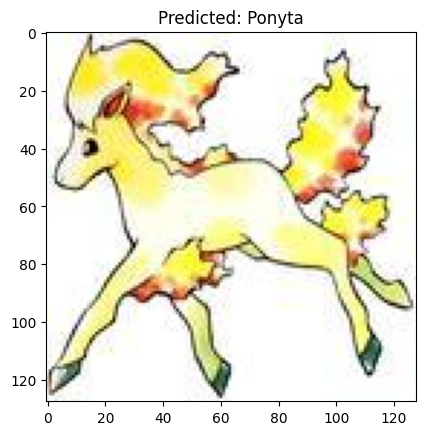

Predicted class: Ponyta for image test_image_8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


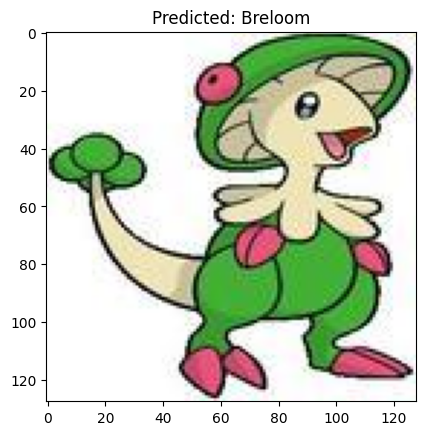

Predicted class: Breloom for image test_image_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


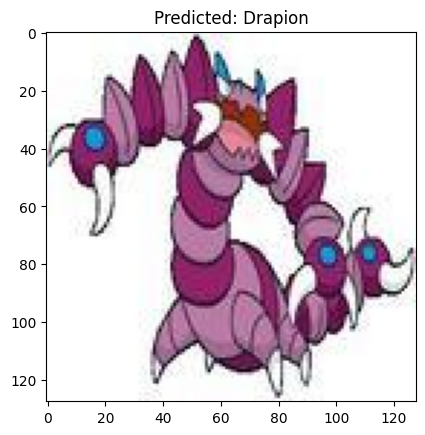

Predicted class: Drapion for image test_image_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


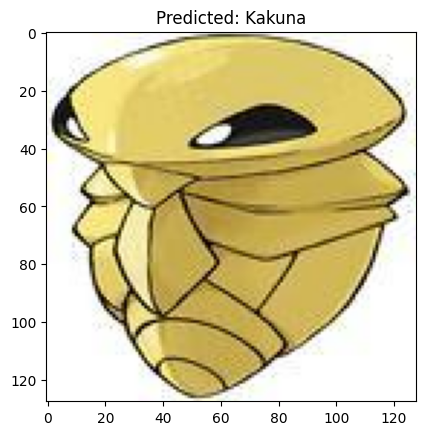

Predicted class: Kakuna for image test_image_6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


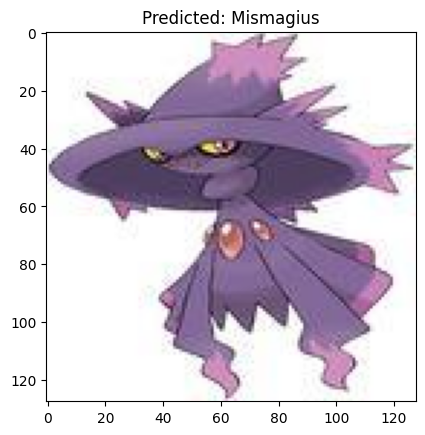

Predicted class: Mismagius for image test_image_7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


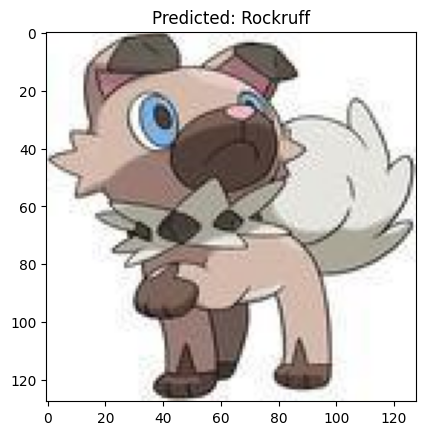

Predicted class: Rockruff for image test_image_10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


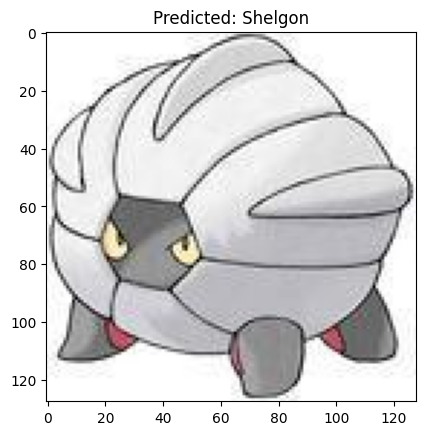

Predicted class: Shelgon for image test_image_11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


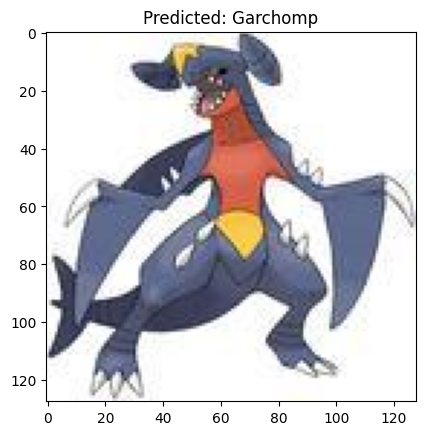

Predicted class: Garchomp for image test_image_5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


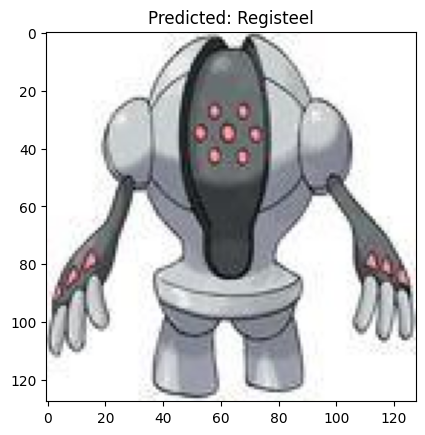

Predicted class: Registeel for image test_image_9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


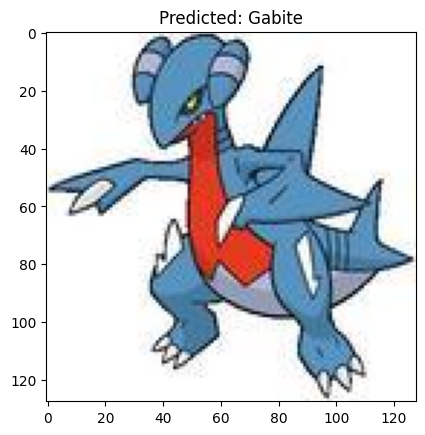

Predicted class: Gabite for image test_image_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


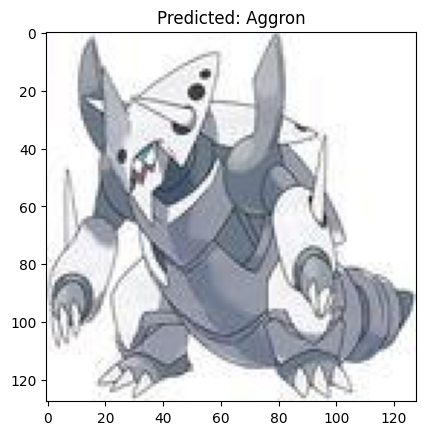

Predicted class: Aggron for image test_image_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


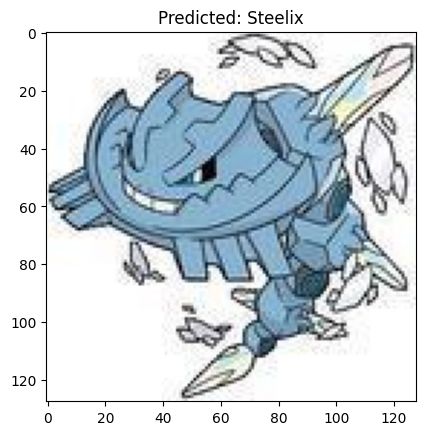

Predicted class: Steelix for image test_image_12.jpg


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = tf.keras.models.load_model('pokemon_identifier_mobilenetv2.h5')

# Path to the test images directory
test_images_dir = '/content/dataset/test/original'

# Loop through all image files in the directory
for filename in os.listdir(test_images_dir):
    # Construct the full path to the image
    image_path = os.path.join(test_images_dir, filename)

    # Check if the file is an image (optional)
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
        # Load and preprocess the image
        img = load_img(image_path, target_size=(128, 128))  # Load the image and resize it
        img_array = img_to_array(img)  # Convert the image to an array
        img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
        img_array /= 255.0  # Normalize the image to [0, 1]

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        # Map the predicted class index to the class label
        class_indices = train_generator.class_indices  # Get the mapping of class indices to labels
        class_labels = {v: k for k, v in class_indices.items()}  # Reverse the dictionary

        predicted_label = class_labels[predicted_class[0]]

        # Display the image and prediction
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_label}')
        plt.show()

        print(f"Predicted class: {predicted_label} for image {filename}")



## Test model against fanart images
---
Due to the lack of unique images used in training, the model does not perform well on images it has not seen, particularly fanart images or cartoon images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


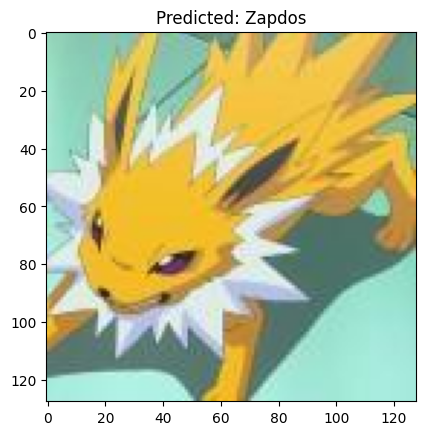

Predicted class: Zapdos for image test_image_8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


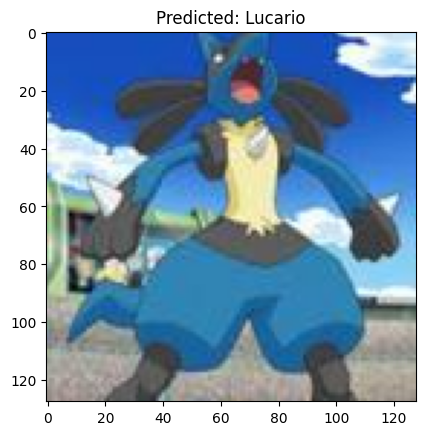

Predicted class: Lucario for image test_image_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


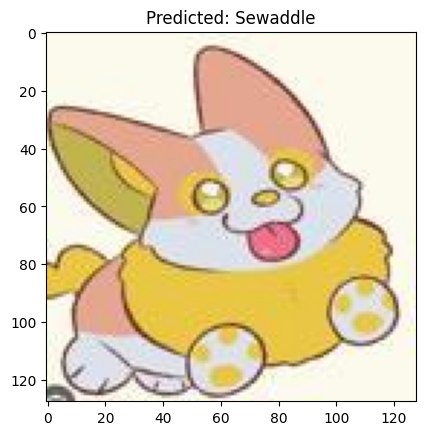

Predicted class: Sewaddle for image test_image_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


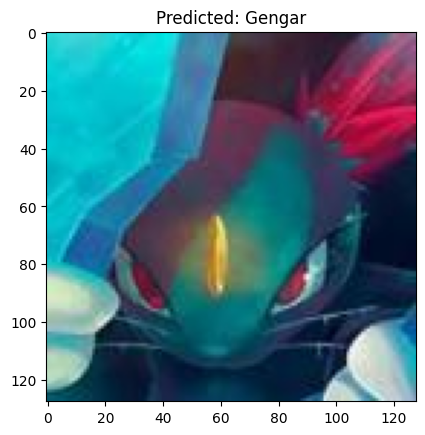

Predicted class: Gengar for image test_image_6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


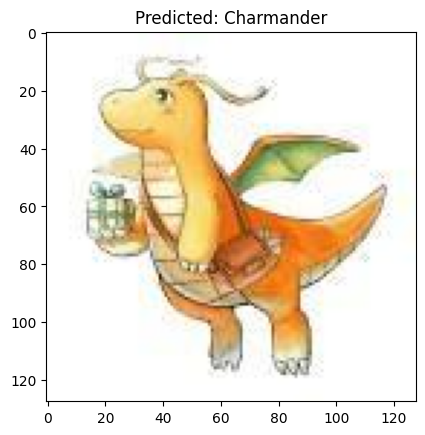

Predicted class: Charmander for image test_image_7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


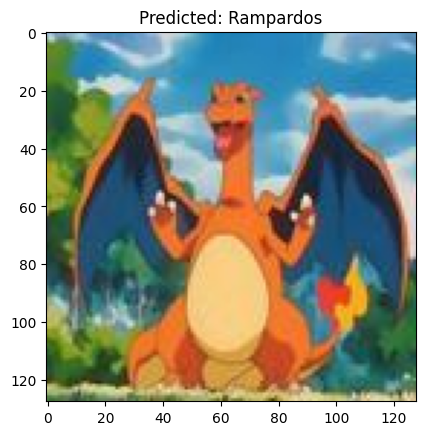

Predicted class: Rampardos for image test_image_10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


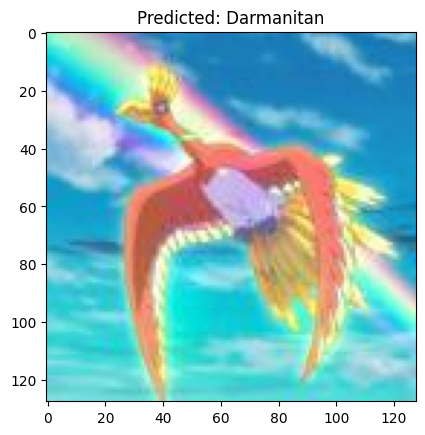

Predicted class: Darmanitan for image test_image_11.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


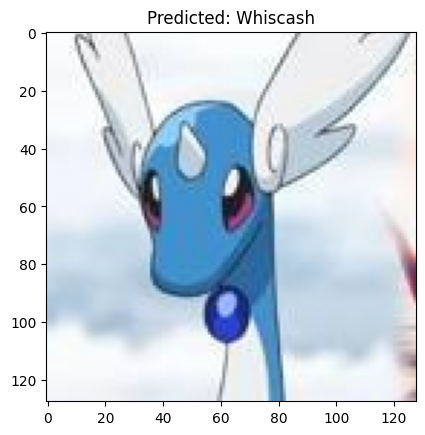

Predicted class: Whiscash for image test_image_5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


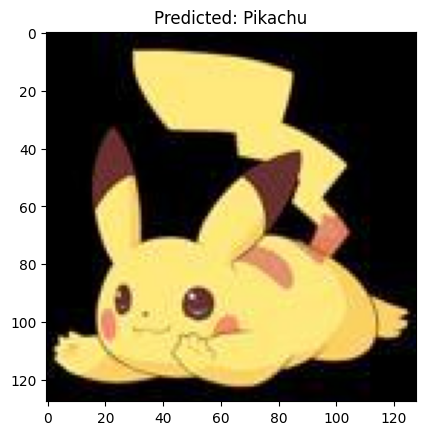

Predicted class: Pikachu for image test_image_9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


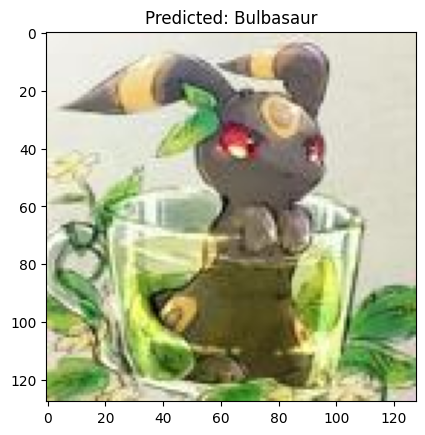

Predicted class: Bulbasaur for image test_image_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


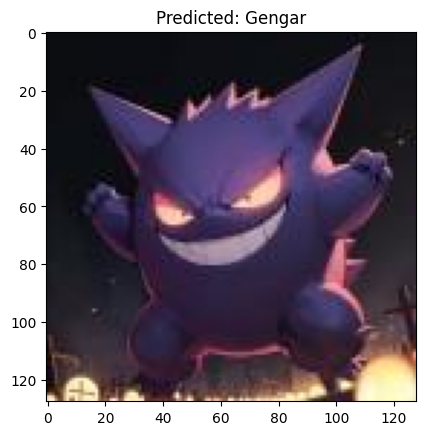

Predicted class: Gengar for image test_image_1.jpg


In [ ]:
# Path to the test images directory
test_images_dir = '/content/dataset/test/fanart'

# Loop through all image files in the directory
for filename in os.listdir(test_images_dir):
    # Construct the full path to the image
    image_path = os.path.join(test_images_dir, filename)

    # Check if the file is an image (optional)
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
        # Load and preprocess the image
        img = load_img(image_path, target_size=(128, 128))  # Load the image and resize it
        img_array = img_to_array(img)  # Convert the image to an array
        img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
        img_array /= 255.0  # Normalize the image to [0, 1]

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        # Map the predicted class index to the class label
        class_indices = train_generator.class_indices  # Get the mapping of class indices to labels
        class_labels = {v: k for k, v in class_indices.items()}  # Reverse the dictionary

        predicted_label = class_labels[predicted_class[0]]

        # Display the image and prediction
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_label}')
        plt.show()

        print(f"Predicted class: {predicted_label} for image {filename}")